# Тема “ Построение надежных схем валидации решения, оптимизация целевых метрик.”


<b>Основное задание:
<ul>Даны выборки для обучения и для тестирования
<li>Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче.
<li>Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud.
<li>Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые.   
<li>Внимание! выборка assignment_2_test.csv - наш аналог лидерборда.   
<li>Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. 
</ul>

***Для других целей использовать выборку запрещено!.***
<hr>
<ul>
Терминалогия, используемая в задании:
<li>обучающая выборка - выборка, которая передается в метод fit / train;
<li>валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
<li>тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
<li>ЛБ - лидерборд, выборка assignment_2_test.csv.
</ul>
    <hr>
Задания:
<ol>
<li><a href="#task_1">Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.
</a>
<li><a href = "#task_2">Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.
</a>
<li><a href = "#task_3">Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.
</a>
<li><a href = "#task_4">Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.
</a>
<li><a href = "#task_5">Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.
</a>
<li><a href = "#task_6">Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.
</a>
<li><a href = "#task_7">Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).
</a>
</ol>

## Импорт библиотек

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
def optimization_memory_usage(df):
    """ 
    Функция оптимизации числовых значений по int[8, 16, 32, 64] по float[16, 32, 64]
    с преобразованием object -> category
    """
    start_memory_usage = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_memory_usage:.2f} MB')
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type != object:
            col_min = df[column].min()
            col_max = df[column].max()
            if str(column_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)

                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)

                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)

                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64) 
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)

                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)

                else:
                    df[column] = df[column].astype(np.float64)
        # else:
        #     df[column] = df[column].astype('category')
            
    end_memory_usage = df.memory_usage().sum() / 1024**2
    percent_optimization  = 100 * (start_memory_usage - end_memory_usage) / start_memory_usage
    print(f'Memory usage after optimization is: {end_memory_usage:.2f} MB')
    print(f'Decreased by {percent_optimization:.1f}%')
    
    return df

## Загрузка данных

In [3]:
train_df = pd.read_csv('../data/assignment_2_train.csv')
lb_test = pd.read_csv('../data/assignment_2_test.csv')

In [4]:
train_df = optimization_memory_usage(train_df)

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 158.10 MB
Decreased by 70.8%


In [5]:
lb_test = optimization_memory_usage(lb_test)

Memory usage of dataframe is 300.60 MB
Memory usage after optimization is: 83.45 MB
Decreased by 72.2%


In [6]:
train_data = train_df.drop('isFraud', axis=1)
train_target = train_df['isFraud']

test_data = lb_test.drop('isFraud', axis=1)
test_target = lb_test['isFraud']



In [7]:
numerical_feature_names = train_data.select_dtypes(include=np.number).columns.tolist()
object_feature_names = train_data.select_dtypes(exclude=np.number).columns.tolist()

In [8]:
train_data = train_data[numerical_feature_names]

test_data = test_data[numerical_feature_names]


## Выполнение заданий

<p><a name="task_1"></a></p>

### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.


In [9]:
df_roc_auc_score = pd.DataFrame()

In [10]:
X_train, X_valid = train_test_split(train_data, train_size=0.75, shuffle=True, random_state=21)
y_train, y_valid = train_test_split(train_target, train_size=0.75, shuffle=True, random_state=21)


In [11]:
params_lgb = {"boosting_type": "gbdt",
              "objective": "binary",
              "metric": "auc",
              "learning_rate": 0.1,
              "n_estimators": 1000,
              "n_jobs": -1,
              "seed": 21
             }

model_lgb = lgb.LGBMClassifier(**params_lgb)

model_lgb.fit(X=X_train, y=y_train,
              eval_set=[(X_train, y_train),
                        (X_valid, y_valid)
                       ],
              early_stopping_rounds=100,
              eval_metric="auc",
              verbose=100)

[100]	training's auc: 0.9708	valid_1's auc: 0.93316
[200]	training's auc: 0.985745	valid_1's auc: 0.939962
[300]	training's auc: 0.993227	valid_1's auc: 0.944271
[400]	training's auc: 0.996819	valid_1's auc: 0.947214
[500]	training's auc: 0.998489	valid_1's auc: 0.949296
[600]	training's auc: 0.999246	valid_1's auc: 0.951001
[700]	training's auc: 0.999651	valid_1's auc: 0.952124
[800]	training's auc: 0.99982	valid_1's auc: 0.952765
[900]	training's auc: 0.99993	valid_1's auc: 0.952265


LGBMClassifier(metric='auc', n_estimators=1000, objective='binary', seed=21)

In [12]:
def get_roc_auc_score(X_train: pd.DataFrame,
                      y_train: pd.Series,
                      suffixes : str,
                      validation_scheme : str)-> pd.DataFrame:

    score = roc_auc_score(y_train, model_lgb.predict_proba(X_train)[:, 1:])
    score_dict = {'validation_scheme': validation_scheme, f'roc_auc_score_{suffixes}': [score]}
    return pd.DataFrame(score_dict)
   
        

In [13]:
train_score = get_roc_auc_score(X_train,
                                y_train,
                                suffixes='train',
                                validation_scheme='Hold_Out_2')
valid_score = get_roc_auc_score(X_valid,
                                y_valid,
                                suffixes='valid',
                                validation_scheme='Hold_Out_2')
test_score = get_roc_auc_score(test_data,
                                test_target,
                                suffixes='test',
                                validation_scheme='Hold_Out_2')


In [14]:
holdout_2 = pd.merge(train_score, valid_score, how ='left', on='validation_scheme')
holdout_2 = pd.merge(holdout_2, test_score, how ='left', on='validation_scheme')
holdout_2

,validation_scheme,roc_auc_score_train,roc_auc_score_valid,roc_auc_score_test
0,Hold_Out_2,0.999824,0.952836,0.818394


<p><a name="task_2"></a></p>

### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер 

In [15]:
X_train, X_valid = train_test_split(train_data, train_size=0.65, shuffle=True, random_state=21)
y_train, y_valid = train_test_split(train_target, train_size=0.65, shuffle=True, random_state=21)

X_valid, X_valid_2 = train_test_split(X_valid, train_size=0.6, shuffle=True, random_state=21)
y_valid, y_valid_2 = train_test_split(y_valid, train_size=0.6, shuffle=True, random_state=21)


In [16]:
model_lgb = lgb.LGBMClassifier(**params_lgb)

model_lgb.fit(X=X_train, y=y_train,
              eval_set=[(X_train, y_train),
                        (X_valid, y_valid)
                       ],
              early_stopping_rounds=100,
              eval_metric="auc",
              verbose=100)

[100]	training's auc: 0.97247	valid_1's auc: 0.93327
[200]	training's auc: 0.987578	valid_1's auc: 0.941006
[300]	training's auc: 0.994187	valid_1's auc: 0.945284
[400]	training's auc: 0.997257	valid_1's auc: 0.946639
[500]	training's auc: 0.998598	valid_1's auc: 0.947761
[600]	training's auc: 0.99944	valid_1's auc: 0.949149
[700]	training's auc: 0.999735	valid_1's auc: 0.950172
[800]	training's auc: 0.999924	valid_1's auc: 0.951123
[900]	training's auc: 0.999982	valid_1's auc: 0.951213


LGBMClassifier(metric='auc', n_estimators=1000, objective='binary', seed=21)

In [17]:
train_score = get_roc_auc_score(X_train,
                                y_train,
                                suffixes='train',
                                validation_scheme='Hold_Out_3')
valid_score = get_roc_auc_score(X_valid,
                                y_valid,
                                suffixes='valid',
                                validation_scheme='Hold_Out_3')
valid2_score = get_roc_auc_score(X_valid_2,
                                 y_valid_2,
                                 suffixes='valid_2',
                                 validation_scheme='Hold_Out_3')
test_score = get_roc_auc_score(test_data,
                               test_target,
                               suffixes='test',
                               validation_scheme='Hold_Out_3')


In [18]:
holdout_3 = pd.merge(train_score, valid_score, how ='left', on='validation_scheme')
holdout_3 = pd.merge(holdout_3, valid2_score, how ='left', on='validation_scheme')
holdout_3 = pd.merge(holdout_3, test_score, how ='left', on='validation_scheme')
holdout_3

,validation_scheme,roc_auc_score_train,roc_auc_score_valid,roc_auc_score_valid_2,roc_auc_score_test
0,Hold_Out_3,0.999936,0.95158,0.947768,0.826736


In [19]:
roc_auc_scores = pd.concat([holdout_2, holdout_3])
roc_auc_scores

,validation_scheme,roc_auc_score_train,roc_auc_score_valid,roc_auc_score_test,roc_auc_score_valid_2
0,Hold_Out_2,0.999824,0.952836,0.818394,NaN
0,Hold_Out_3,0.999936,0.951580,0.826736,0.947768


<p><a name="task_3"></a></p>

### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.


In [20]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [21]:
np.random.seed(21)

scores = create_bootstrap_metrics(test_target,
                                  model_lgb.predict_proba(test_data)[:, 1:],
                                  roc_auc_score)

calculate_confidence_interval(scores)


(0.818791152860671, 0.8340037776833555)

<p><a name="task_4"></a></p>

### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.


In [22]:
df_train = train_df.drop('isFraud', axis=1).copy()
df_test = lb_test.drop('isFraud', axis=1).copy()

In [23]:
df_train.head(3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_test.head(3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3287002,7415081,320.0,W,13844,583.0,150.0,visa,226.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# заполнение пропусков категориальных признаков "<nan>"
df_train.loc[:, object_feature_names] = df_train[object_feature_names].fillna('<nan>')
df_test.loc[:, object_feature_names] = df_test[object_feature_names].fillna('<nan>')

# заполнение пропусков числовых признаков -99.9
df_train = df_train.fillna(-99)
df_test = df_test.fillna(-99)
adv_features = df_train.columns.to_list()

adv_target = 'adversarial_target'
df_train[adv_target] = 0
df_test[adv_target] = 1

df_train.head(3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,adversarial_target
0,2987000,86400,68.5,W,13926,-99.0,150.0,discover,142.0,credit,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0


In [26]:
df_test.head(3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,adversarial_target
0,3287000,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1
1,3287001,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1
2,3287002,7415081,320.0,W,13844,583.0,150.0,visa,226.0,credit,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1


In [27]:
df_train.shape, df_test.shape

((180000, 394), (100001, 394))

In [28]:
def create_adversarial_data(df_train, df_test, cols=False, N_val=50000):
    if not cols:
        cols = df_train.columns.to_list()
    df_main = pd.concat([df_train[cols], df_test[cols]], axis=0)
    
    adversarial_test = df_main.sample(N_val, replace=False)
    adversarial_train = df_main[~df_main.index.isin(adversarial_test.index)]
    
    return adversarial_train, adversarial_test

In [29]:
(adversarial_train,
 adversarial_test) = create_adversarial_data(df_train, df_test)

adversarial_train.shape, adversarial_test.shape

((200606, 394), (50000, 394))

In [30]:
adv_train_data = Pool(
    data=adversarial_train[adv_features],
    label=adversarial_train[adv_target],
    cat_features=object_feature_names
)

adv_holdout_data = Pool(
    data=adversarial_test[adv_features],
    label=adversarial_test[adv_target],
    cat_features=object_feature_names
)

In [31]:
adv_params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
}

adv_model = CatBoostClassifier(**adv_params)
_ = adv_model.fit(adv_train_data,
                  eval_set=adv_holdout_data,
                  plot=True, verbose=False)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr,
                label='%s; AUC=%.3f' % (labels[i], auc),
                marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')



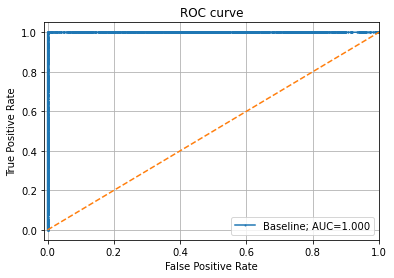

In [33]:
plot_roc(
    [adv_holdout_data.get_label()],
    [adv_model.predict_proba(adv_holdout_data)[:,1]],
    ['Baseline']
)

In [34]:
y_pred_adv = adv_model.predict_proba(adv_holdout_data)
score = roc_auc_score(adv_holdout_data.get_label(), y_pred_adv[:, 1])
print(round(score, 4))

1.0


In [35]:
y_pred = adv_model.predict_proba(df_train)
y_pred

array([[9.99985884e-01, 1.41160568e-05],
       [9.99983687e-01, 1.63129297e-05],
       [9.99980232e-01, 1.97677578e-05],
       ...,
       [6.60444289e-02, 9.33955571e-01],
       [2.76191793e-01, 7.23808207e-01],
       [6.61851354e-02, 9.33814865e-01]])

In [36]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    179916
(0.1, 0.2]         0
(0.2, 0.3]         2
(0.3, 0.4]         1
(0.4, 0.5]         1
(0.5, 0.6]         1
(0.6, 0.7]         1
(0.7, 0.8]        11
(0.8, 0.9]        26
(0.9, 1.0]        41
dtype: int64

<p><a name="task_5"></a></p>

### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [37]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [38]:
cv_strategy = KFold(n_splits=5, random_state=21, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train_data[numerical_feature_names], train_target, model_lgb, metric=roc_auc_score, cv_strategy=cv_strategy
)


Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9774, valid-score = 0.7905
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.9795, valid-score = 0.8056
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.9725, valid-score = 0.7983
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.9766, valid-score = 0.8031
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.9788, valid-score = 0.7937
CV-results train: 0.977 +/- 0.002
CV-results valid: 0.7982 +/- 0.006
OOF-score = 0.7982


<p><a name="task_6"></a></p>

### Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.


<p><a name="task_7"></a></p>

### Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).
